# Task 1 Predict odor or odorless.


# Notebook Preparation

In [1]:
import os
import sys

try:
    ##################################################################################
    import google.colab
    print("Running on Google Colab. Mounting Google Drive...")

    from google.colab import drive, files
    drive.mount("/content/drive",
    force_remount=True
    )

    main_directory_path = "./drive/My Drive/Group14/"
    data_path = main_directory_path + "Code/"
    output_path = data_path + "Output/"
    plot_path = output_path + "Plots/"
    dataset_path = data_path + "Dataset/"
    features_path = data_path + "Features/"
    script_path = data_path + 'Scripts/'
    model_weights_occ_path = data_path + 'Models/OCC/'
    sys.path.append(script_path)

    print("Gooogle Drive mounted!")
    ##################################################################################


    ##################################################################################
    print("Loading Functions...")

    # import EDA_Functions
    # import Feature_Extraction
    import OCC_Functions
    import OCC_High_Level_Fusion

    print("Functions are ready!")
    ##################################################################################

except ImportError:
    print("Running in a local environment.")

    # main_directory_path = "./drive/My Drive/Colab Notebooks/RDkit experimentation/"
    # script_path = main_directory_path + 'Scripts/'
    # data_path = main_directory_path + "Data/"
    # dataset_path = data_path + "Dataset/"
    # features_path = data_path + "Features/"

Running on Google Colab. Mounting Google Drive...
Mounted at /content/drive
Gooogle Drive mounted!
Loading Functions...
Running in a local environment.


Install

In [2]:
# Installation commands
!pip install --upgrade -q rdkit py3Dmol pyod keras-tuner visualkeras
# !pip install --upgrade -q pydot graphviz h2o

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 16.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 64.3 MB/s eta 0:00:00


Imports

In [3]:
# Local application/library specific imports
from OCC_Functions import *
from OCC_High_Level_Fusion import *

# Standard libraries
import os
import json
import h5py
import gc
import numpy as np
import pandas as pd
from collections import Counter
from platform import python_version
from IPython.display import Image, display

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning, Data Preprocessing, and Metrics
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, OneClassSVM
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve,
    precision_recall_curve, auc
)

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.compat.v1 import reset_default_graph
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Recall, Precision, AUC
from tensorflow.keras.regularizers import l1
from tensorflow.keras.utils import plot_model

# Keras-Tuner
from keras_tuner import HyperModel

# Visual Keras
import visualkeras

# 3D modeling
import py3Dmol

# # H2O AutoML
# import h2o
# from h2o.automl import H2OAutoML

# PyOD
from pyod.models.auto_encoder import AutoEncoder
from pyod.utils.data import evaluate_print

# tqdm for progress bars
from tqdm.notebook import tqdm

# Prepare data

In [4]:
dataset_ex = ['']#["_binary_multi.csv"]
datasets = [f for f in os.listdir(dataset_path) if f.endswith(".csv") and f not in dataset_ex]
datasets

['smiles_descriptors_binary_multi.csv',
 'smiles_descriptors_processed_minmax_binary_multi.csv',
 'smiles_descriptors_fingerprints_fused_binary_multi.csv',
 'smiles_fingerprints_binary_multi.csv']

In [5]:
dataset = datasets[0]
dataset

'smiles_descriptors_binary_multi.csv'

In [6]:
df = pd.read_csv(dataset_path + dataset)
# print(df.head())
# print("\nShape: ", df.shape)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4316 entries, 0 to 4315
Columns: 215 entries, SMILES to SPS.1
dtypes: float64(107), int64(105), object(3)
memory usage: 7.1+ MB


In [7]:
unique_values = df['binary'].unique()
unique_values, len(unique_values)

(array([0, 1]), 2)

In [8]:
# Odorless, With odors
df[df['binary']==1].shape, df[df['binary']==0].shape

((57, 215), (4259, 215))

# Device information:

In [ ]:
!nvidia-smi -L

GPU 0: NVIDIA A100-SXM4-40GB (UUID: GPU-7118a8eb-143b-17ae-49f0-0822685dbf8a)


In [ ]:
!nvidia-smi -q


==============NVSMI LOG==============

Timestamp                                 : Mon Jan 22 12:06:59 2024
Driver Version                            : 535.104.05
CUDA Version                              : 12.2

Attached GPUs                             : 1
GPU 00000000:00:04.0
    Product Name                          : NVIDIA A100-SXM4-40GB
    Product Brand                         : NVIDIA
    Product Architecture                  : Ampere
    Display Mode                          : Enabled
    Display Active                        : Disabled
    Persistence Mode                      : Disabled
    Addressing Mode                       : None
    MIG Mode
        Current                           : Disabled
        Pending                           : Disabled
    Accounting Mode                       : Disabled
    Accounting Mode Buffer Size           : 4000
    Driver Model
        Current                           : N/A
        Pending                           : N/A
    Serial

In [ ]:
!nvidia-smi

Mon Jan 22 12:07:05 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0              47W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
!lscpu |grep 'Model name'

Model name:                         Intel(R) Xeon(R) CPU @ 2.20GHz


In [ ]:
!lscpu

Architecture:            x86_64
  CPU op-mode(s):        32-bit, 64-bit
  Address sizes:         46 bits physical, 48 bits virtual
  Byte Order:            Little Endian
CPU(s):                  12
  On-line CPU(s) list:   0-11
Vendor ID:               GenuineIntel
  Model name:            Intel(R) Xeon(R) CPU @ 2.20GHz
    CPU family:          6
    Model:               85
    Thread(s) per core:  2
    Core(s) per socket:  6
    Socket(s):           1
    Stepping:            7
    BogoMIPS:            4400.34
    Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clf
                         lush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_
                         good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fm
                         a cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hyp
                         ervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd

In [ ]:
!free -h --si | awk  '/Mem:/{print $2}'

85G


# Run!!!

In [9]:
datasets = [datasets[1],datasets[3],datasets[2]]
dataset_names = ["descriptors", "morgan_fp", "midlevel_fused"]
datasets

['smiles_descriptors_processed_minmax_binary_multi.csv',
 'smiles_fingerprints_binary_multi.csv',
 'smiles_descriptors_fingerprints_fused_binary_multi.csv']

In [10]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     try:
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#     except RuntimeError as e:
#         print(e)

## BINARY:

Firslty, lets try binary classification 2 differente models for each dataset:
1. Descriptors
  *   SVC - Binary Classification
  *   Custom Binary DL Model- Binary Classification
2. Fingerprints
  *   SVC - Binary Classification
  *   Custom Binary DL Model- Binary Classification
3. Fused: Descriptors + Fingerprints
  *   SVC - Binary Classification
  *   Custom Binary DL Model- Binary Classification

In [ ]:
for d in datasets:
  gc.collect()
  print('___________________________________')
  print('___________________________________')
  print(d)
  df = pd.read_csv(dataset_path + d)
  # print(df.head())
  print("\nShape: ", df.shape)
  print(df.info())
  print('___________________________________')
  print('___________________________________')

  bcc_occ_models(df, classification='bcc')
  gc.collect()

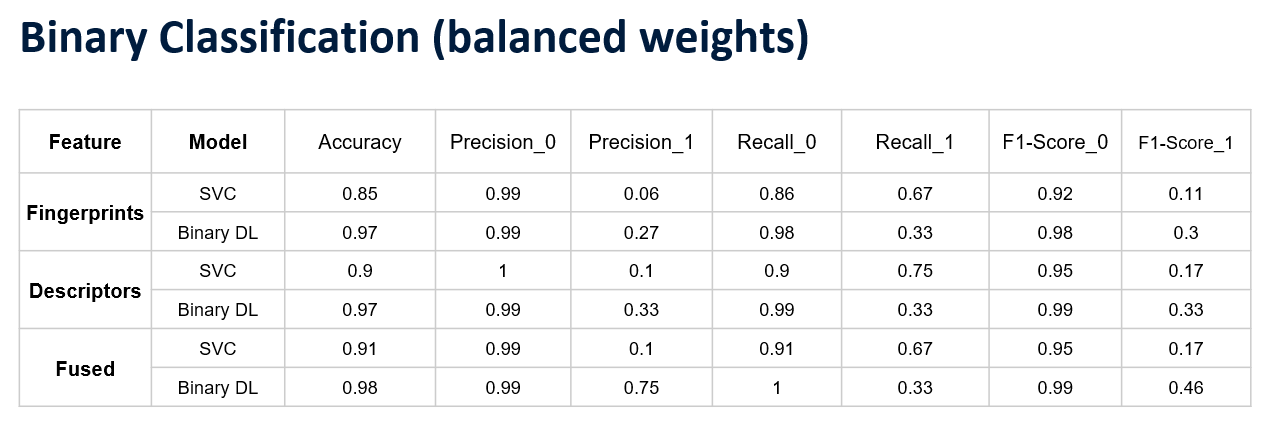

## ANOMALY DETECTION

Now lets try anomaly detection or one-class classification. 2 differente models for each dataset:
1. Descriptors
  *   OC-SVM - Anomaly Detection
  *   AutoEncoder - Anomaly Detection
2. Fingerprints
  *   OC-SVM - Anomaly Detection
  *   AutoEncoder - Anomaly Detection
3. Fused: Descriptors + Fingerprints
  *   OC-SVM - Anomaly Detection
  *   AutoEncoder - Anomaly Detection



In [ ]:
for d in datasets:
  gc.collect()
  print('___________________________________')
  print('___________________________________')
  print(d)
  print('-----------------------------------')
  df = pd.read_csv(dataset_path + d)
  # print(df.head())
  print("\nShape: ", df.shape)
  print(df.info())
  print('___________________________________')
  print('___________________________________')

  bcc_occ_models(df, classification='occ')
  gc.collect()

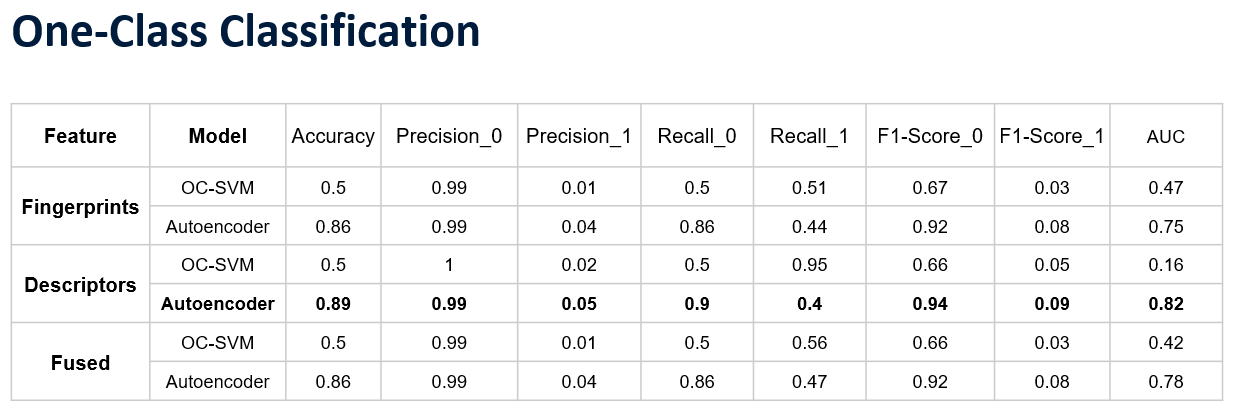

## High and Mid Level Fusion only for Autoencoders

3 Differenet models (as Autoencoders for anomaly detection or one-class classification)

1. AutoEncoder - Anomaly Detection - Descriptors
2. AutoEncoder - Anomaly Detection - Morgan Fingerprints
3. AutoEncoder - Anomaly Detection - Fused: Descriptors + Morgan Fingerprints
4. Bayesian Decision Fusion with 2 models: Descriptors and Morgan Fingerprints
5. Weighted Voting Fusion with 2 models: Descriptors and Morgan Fingerprints


___________________________________
___________________________________
#################################
AutoEncoder - Anomaly Detection - Descriptors
#################################
#################################
# AutoEncoder - Anomaly Detection
#################################
Epoch 1/50
54/54 [==============================] - 7s 15ms/step - loss: 0.1366 - val_loss: 0.0233
Epoch 2/50
54/54 [==============================] - 1s 10ms/step - loss: 0.0344 - val_loss: 0.0101
Epoch 3/50
54/54 [==============================] - 0s 9ms/step - loss: 0.0272 - val_loss: 0.0100
Epoch 4/50
54/54 [==============================] - 0s 9ms/step - loss: 0.0244 - val_loss: 0.0141
Epoch 5/50
54/54 [==============================] - 0s 9ms/step - loss: 0.0233 - val_loss: 0.0120
Epoch 6/50
54/54 [==============================] - 0s 9ms/step - loss: 0.0191 - val_loss: 0.0096
Epoch 7/50
54/54 [==============================] - 0s 9ms/step - loss: 0.0162 - val_loss: 0.0088
Epoch 8/50
54/54 [======

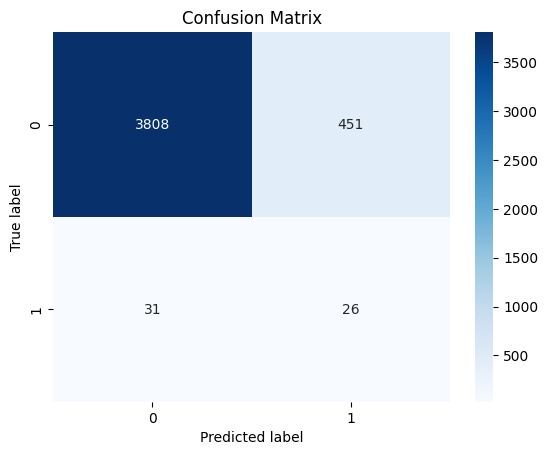

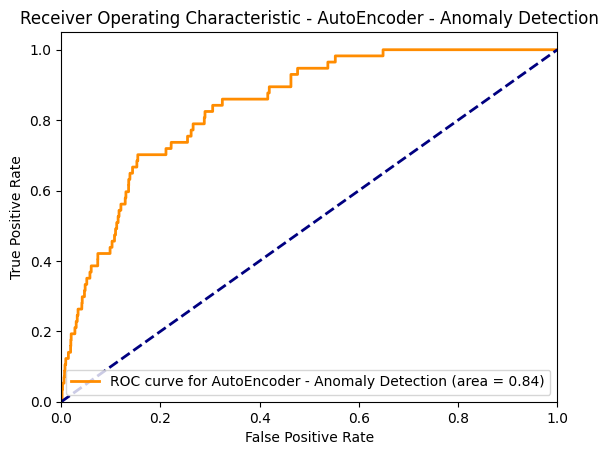

___________________________________
___________________________________
#################################
AutoEncoder - Anomaly Detection - Morgan Fingerprints
#################################
#################################
# AutoEncoder - Anomaly Detection
#################################
Epoch 1/50
54/54 [==============================] - 6s 17ms/step - loss: 0.2143 - val_loss: 0.0959
Epoch 2/50
54/54 [==============================] - 1s 10ms/step - loss: 0.0369 - val_loss: 0.0148
Epoch 3/50
54/54 [==============================] - 1s 10ms/step - loss: 0.0145 - val_loss: 0.0126
Epoch 4/50
54/54 [==============================] - 1s 10ms/step - loss: 0.0132 - val_loss: 0.0123
Epoch 5/50
54/54 [==============================] - 1s 11ms/step - loss: 0.0124 - val_loss: 0.0100
Epoch 6/50
54/54 [==============================] - 1s 11ms/step - loss: 0.0125 - val_loss: 0.0107
Epoch 7/50
54/54 [==============================] - 1s 11ms/step - loss: 0.0114 - val_loss: 0.0099
Epoch 8/50


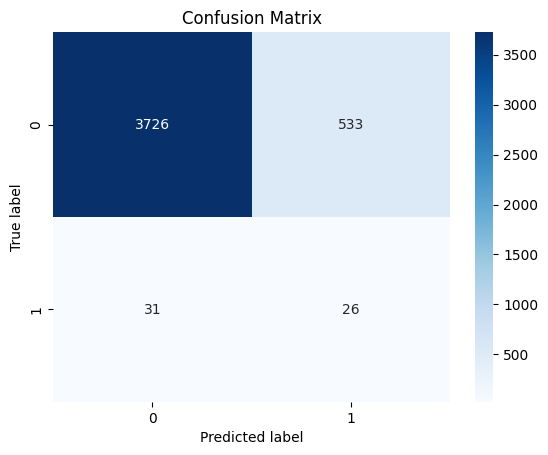

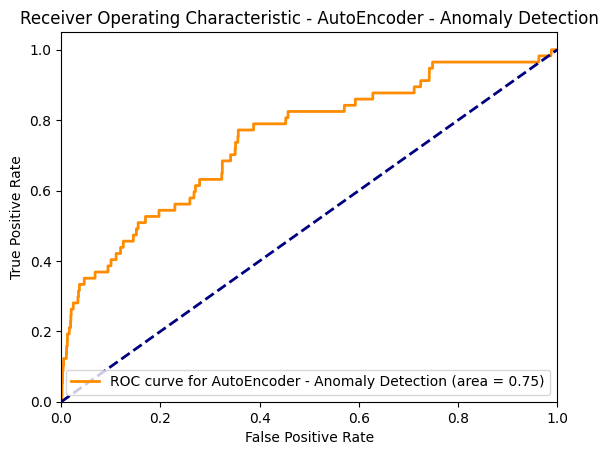

___________________________________
___________________________________
#################################
AutoEncoder - Anomaly Detection - Fused: Descriptors + Morgan Fingerprints
#################################
#################################
# AutoEncoder - Anomaly Detection
#################################
Epoch 1/50
54/54 [==============================] - 6s 17ms/step - loss: 0.2072 - val_loss: 0.0878
Epoch 2/50
54/54 [==============================] - 1s 10ms/step - loss: 0.0322 - val_loss: 0.0131
Epoch 3/50
54/54 [==============================] - 1s 10ms/step - loss: 0.0125 - val_loss: 0.0108
Epoch 4/50
54/54 [==============================] - 1s 10ms/step - loss: 0.0101 - val_loss: 0.0097
Epoch 5/50
54/54 [==============================] - 1s 10ms/step - loss: 0.0094 - val_loss: 0.0092
Epoch 6/50
54/54 [==============================] - 1s 10ms/step - loss: 0.0087 - val_loss: 0.0085
Epoch 7/50
54/54 [==============================] - 1s 10ms/step - loss: 0.0084 - val_los

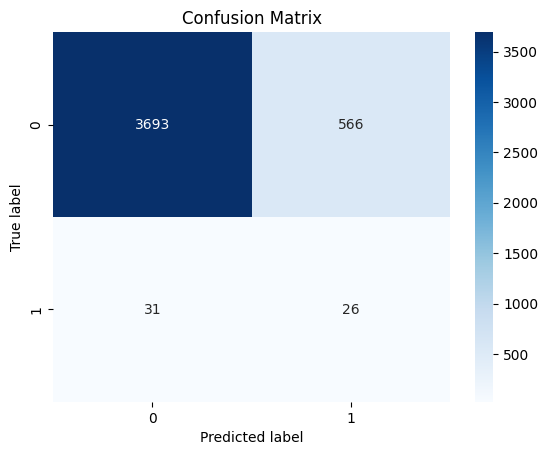

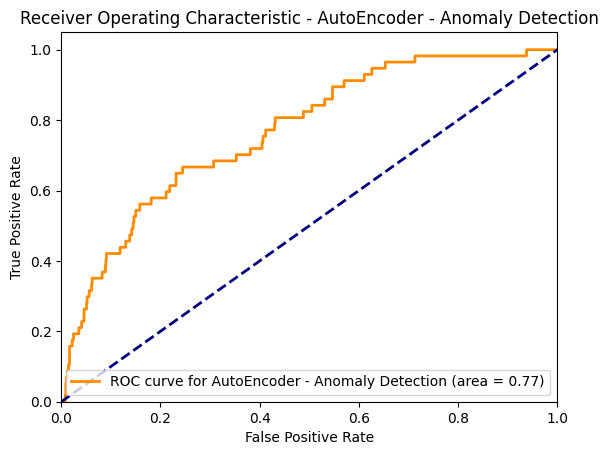

135/135 [==============================] - 0s 2ms/step
___________________________________
___________________________________
#################################
AutoEncoder - Anomaly Detection
Bayesian Decision Fusion with 2 models: Descriptors and Morgan Fingerprints
#################################
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.81      0.89      4259
           1       0.04      0.61      0.08        57

    accuracy                           0.80      4316
   macro avg       0.52      0.71      0.48      4316
weighted avg       0.98      0.80      0.88      4316

Confusion Matrix:


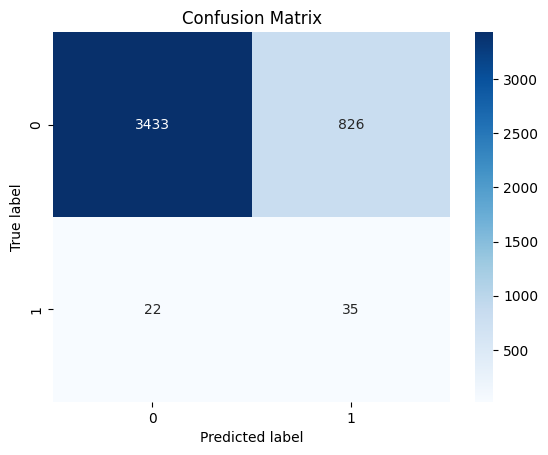

___________________________________
___________________________________
#################################
AutoEncoder - Anomaly Detection
Weighted Voting Fusion with 2 models: Descriptors and Morgan Fingerprints
#################################
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      4259
           1       0.10      0.30      0.15        57

    accuracy                           0.95      4316
   macro avg       0.54      0.63      0.56      4316
weighted avg       0.98      0.95      0.97      4316

Confusion Matrix:


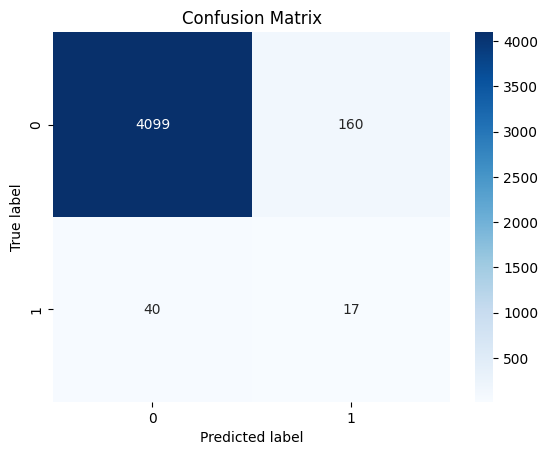

In [ ]:
d1,d2,d3 = datasets
gc.collect()
print('___________________________________')
print('___________________________________')
print('AutoEncoder - Anomaly Detection - Descriptors')
# print(d1)

df1 = pd.read_csv(dataset_path + d1)
model1, X1, y1, threshold1 = modelizer(df1, classification='occ')
gc.collect()
print('___________________________________')
print('___________________________________')
print('AutoEncoder - Anomaly Detection - Morgan Fingerprints')
# print(d2)
df2 = pd.read_csv(dataset_path + d2)
model2, X2, y2, threshold2= modelizer(df2, classification='occ')
print('___________________________________')
print('___________________________________')
print('AutoEncoder - Anomaly Detection - Fused: Descriptors + Morgan Fingerprints')
# print(d3)
df3 = pd.read_csv(dataset_path + d3)
model3, X3, y3, threshold3= modelizer(df3, classification='occ')


thresholds = [threshold1,threshold2]
# Bayesian Fusion
conf_matrices = confusion_matrices([model1, model2], [(X1, y1), (X2, y2)], thresholds)
final_predictions_bayesian = bayesian_fusion_predict([model1, model2], [X1, X2], conf_matrices, thresholds)
# Weighted Voting Fusion
final_predictions_weighted = weighted_voting_fusion_autoencoder([model1, model2], [X1, X2], thresholds)


def conf_matrix_aucroc_and_classif_report(true, pred, model_name):
    """
    Print the classification report, confusion matrix, plot ROC curve, and calculate ROC AUC score for the true labels and predictions.

    Parameters:
        true (array-like): The true labels.
        pred (array-like): The predicted labels.
        model_name (str): The name of the model or method being evaluated.

    Returns:
        None: The function prints the classification report, confusion matrix, plots the ROC curve, and ROC AUC score.
    """
    print('Classification Report:')
    print(classification_report(true, pred))

    print('Confusion Matrix:')
    conf_matrix = confusion_matrix(true, pred)
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

    # Calculate and plot ROC curve and AUC
    fpr, tpr, _ = roc_curve(true, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend(loc="lower right")
    plt.show()

    print(f'ROC AUC Score: {roc_auc:.4f}')

# Evaluate the fusion result
print('___________________________________')
print('___________________________________')
print('#################################')
print('AutoEncoder - Anomaly Detection')
print("Bayesian Decision Fusion with 2 models: Descriptors and Morgan Fingerprints")
print('#################################')
conf_matrix_and_classif_report(y1, final_predictions_bayesian, 'Bayesian Decision Fusion')

print('___________________________________')
print('___________________________________')
print('#################################')
print('AutoEncoder - Anomaly Detection')
print("Weighted Voting Fusion with 2 models: Descriptors and Morgan Fingerprints")
print('#################################')
conf_matrix_and_classif_report(y1, final_predictions_weighted, 'Weighted Voting Fusion')

## Optimize the models using Keras-Tuner and then High Level Fusion

In [ ]:
datasets = [f for f in os.listdir(dataset_path) if f.endswith(".csv") and f not in dataset_ex]
datasets = [datasets[1], datasets[3], datasets[2]]# datasets = datasets[2:3]#datasets[0:2]
dataset_names = ["descriptors", "morgan_fp","midlevel_fused"]

In [ ]:
data = []
models = []
thresholds = []
hyperparameters = []

for data_name, name in zip(datasets, dataset_names):
    print(f'#################################')
    print(f'# {name.upper()}')
    print(f'#################################')
    df = pd.read_csv(dataset_path + data_name)

    # Run the keras tuner
    model, best_hyperparameters, X, y, threshold = run_keras_tuner(df, epochs=50)
    data.append((X, y))
    models.append(model)
    hyperparameters.append(best_hyperparameters)
    thresholds.append(threshold)

    # Save the full model
    model_file_path = f"{model_weights_occ_path}{name}.keras"
    model.save(model_file_path)

    # Save the weights of the model
    model_weights_path = f"{model_weights_occ_path}{name}_weights.keras"
    model.save_weights(model_weights_path)

    # Save the hyperparameters
    serializable_hyperparameters = {hp.name: best_hyperparameters.get(hp.name) for hp in best_hyperparameters.space}
    hyperparameters_path = f"{model_weights_occ_path}{name}_hyperparameters.json"
    with open(hyperparameters_path, 'w') as f:
        json.dump(serializable_hyperparameters, f)

    # Clear the Keras session
    K.clear_session()
    gc.collect()

Trial 90 Complete [00h 01m 01s]
val_loss: 0.011374857276678085

Best val_loss So Far: 0.0031257744412869215
Total elapsed time: 00h 15m 36s
107/107 [==============================] - 0s 2ms/step


### Load Best models with weights.

In [ ]:
# asym = '/content/drive/MyDrive/Group14/Code/Models/OCC/extra_old/no_symmetric_autoencoders/' # Assymetrical
sym = '/content/drive/My Drive/Group14/Code/Models/OCC/' # Symmetrical
model_weights_occ_path = sym

#################################
# DESCRIPTORS
#################################


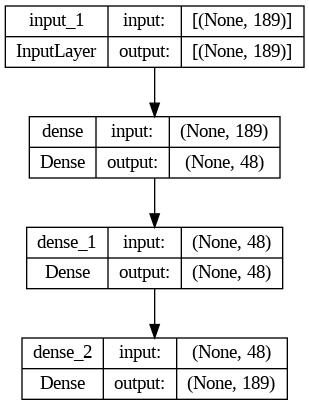

#################################
# MORGAN_FP
#################################


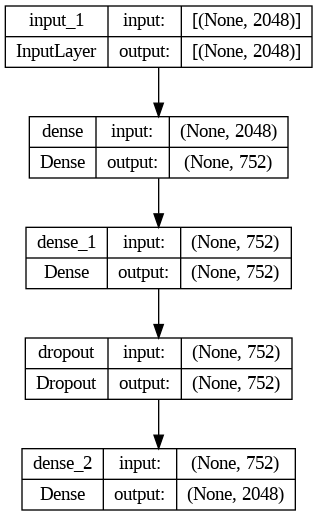

#################################
# MIDLEVEL_FUSED
#################################


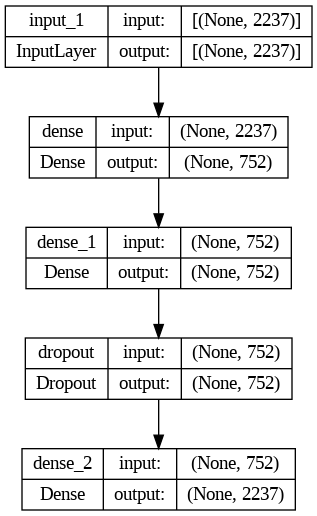

In [ ]:
# Directory paths and model names
models_path = model_weights_occ_path
model_names = ["descriptors", "morgan_fp", "midlevel_fused"]
models=[]

for i, model_name in enumerate(model_names):
    print(f'#################################')
    print(f'# {model_name.upper()}')
    print(f'#################################')

    # Load the model
    model = load_model(os.path.join(models_path, f"{model_name}.keras"))
    model.load_weights(os.path.join(models_path, f"{model_name}_weights.keras"))
    models.append(model)

    # 2D Diagram
    plot_file_path = os.path.join(models_path, f"{model_name}_diagram.png")
    plot_model(model, to_file=plot_file_path, show_shapes=True, show_layer_names=True)
    display(Image(plot_file_path))

    # 3D Diagram with visualkeras
    visualkeras_file_path = os.path.join(models_path, f"{model_name}_3D.png")
    visualkeras.layered_view(model, legend=True, to_file=visualkeras_file_path)
    visualkeras.layered_view(model, legend=True).show()


In [ ]:
for model in models:
   model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 189)]             0         
                                                                 
 dense (Dense)               (None, 128)               24320     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 128)               8320      
                                                                 
 dense_4 (Dense)             (None, 189)               24381     
                                                                 
Total params: 69437 (271.24 KB)
Trainable params: 69437 (271.

In [ ]:
hyperparameters[0].values

{'num_layers': 2,
 'units_encoder_0': 128,
 'encoder_activation': 'tanh',
 'l1_reg': 7.814271492491679e-05,
 'encoder_dropout': False,
 'decoder_activation': 'relu',
 'decoder_dropout': False,
 'learning_rate': 0.005398686009616178,
 'units_encoder_1': 64,
 'units_encoder_2': 32,
 'dropout_rate': 0.25380686613734454,
 'tuner/epochs': 50,
 'tuner/initial_epoch': 17,
 'tuner/bracket': 3,
 'tuner/round': 3,
 'tuner/trial_id': '0046',
 'units_encoder_3': 16}

In [ ]:
hyperparameters[1].values

{'num_layers': 1,
 'units_encoder_0': 512,
 'encoder_activation': 'relu',
 'l1_reg': 1.7883448675054024e-05,
 'encoder_dropout': True,
 'decoder_activation': 'relu',
 'decoder_dropout': False,
 'learning_rate': 0.0012613886291257636,
 'units_encoder_1': 256,
 'units_encoder_2': 256,
 'units_encoder_3': 128,
 'units_encoder_4': 32,
 'dropout_rate': 0.11858361862555121,
 'tuner/epochs': 50,
 'tuner/initial_epoch': 17,
 'tuner/bracket': 1,
 'tuner/round': 1,
 'tuner/trial_id': '0080'}

In [ ]:
hyperparameters[2].values

{'num_layers': 1,
 'units_encoder_0': 512,
 'encoder_activation': 'relu',
 'l1_reg': 4.205190731402481e-05,
 'encoder_dropout': True,
 'decoder_activation': 'relu',
 'decoder_dropout': False,
 'learning_rate': 0.0008047741725190018,
 'dropout_rate': 0.2695624230823106,
 'units_encoder_1': 512,
 'units_encoder_2': 256,
 'units_encoder_3': 64,
 'units_encoder_4': 32,
 'tuner/epochs': 50,
 'tuner/initial_epoch': 17,
 'tuner/bracket': 3,
 'tuner/round': 3,
 'tuner/trial_id': '0046'}

### Best models + High Level RESULTS

In [ ]:
data = []
thresholds = []
dataset_names = ["descriptors", "morgan_fp","midlevel_fused"]
for i, (model, data_name) in enumerate(zip(models, datasets)):
# for data_name in datasets:
    df = pd.read_csv(dataset_path + data_name)
    X = df.drop(['SMILES', 'SENTENCE', 'binary', 'multi'], axis=1)
    y = df['binary']
    data.append((X, y))
    X_train, X_val, _, _ = prepare_for_train(X, y)
    thresholds.append(calculate_threshold(model, X_train, percentile=95))

107/107 [==============================] - 0s 2ms/step


In [ ]:
thresholds

[0.0015661429320991233, 0.005377637827768922, 0.0037255543003152725]

#####################################
# DESCRIPTORS BEST MODEL
#####################################
Threshold:  0.0015661429320991233
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 189)]             0         
                                                                 
 dense (Dense)               (None, 48)                9120      
                                                                 
 dense_1 (Dense)             (None, 48)                2352      
                                                                 
 dense_2 (Dense)             (None, 189)               9261      
                                                                 
Total params: 20733 (80.99 KB)
Trainable params: 20733 (80.99 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
135/135 [=============

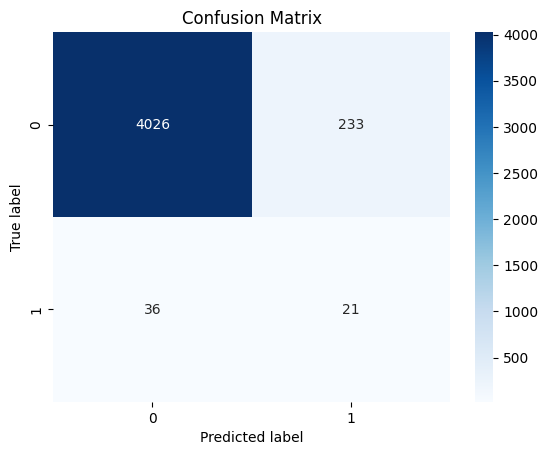

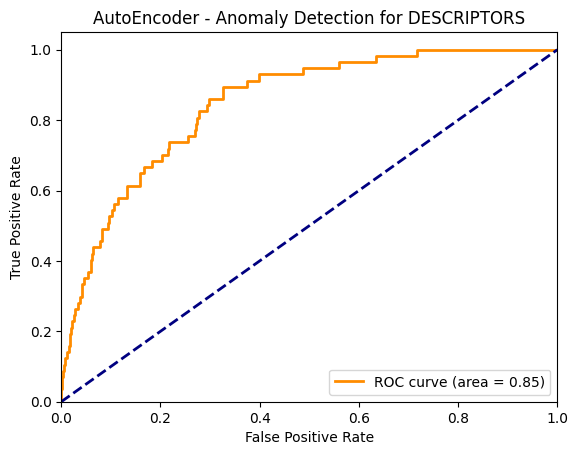

#####################################
# MORGAN_FP BEST MODEL
#####################################
Threshold:  0.005377637827768922
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2048)]            0         
                                                                 
 dense (Dense)               (None, 752)               1540848   
                                                                 
 dense_1 (Dense)             (None, 752)               566256    
                                                                 
 dropout (Dropout)           (None, 752)               0         
                                                                 
 dense_2 (Dense)             (None, 2048)              1542144   
                                                                 
Total params: 3649248 (13.92 MB)
Trainable params: 3649248 (1

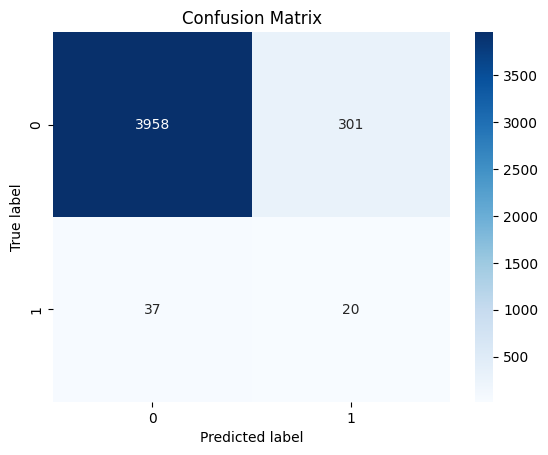

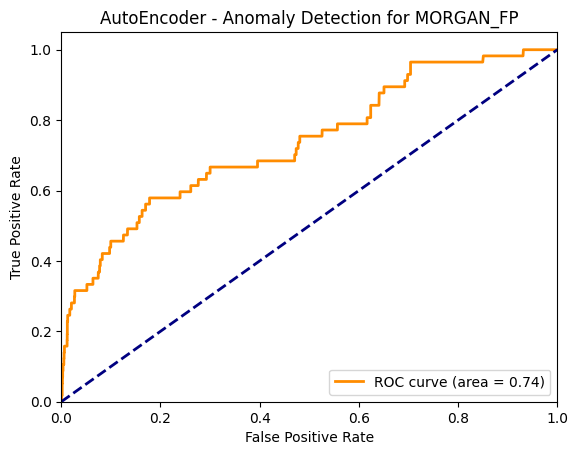

#####################################
# MIDLEVEL_FUSED BEST MODEL
#####################################
Threshold:  0.0037255543003152725
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2237)]            0         
                                                                 
 dense (Dense)               (None, 752)               1682976   
                                                                 
 dense_1 (Dense)             (None, 752)               566256    
                                                                 
 dropout (Dropout)           (None, 752)               0         
                                                                 
 dense_2 (Dense)             (None, 2237)              1684461   
                                                                 
Total params: 3933693 (15.01 MB)
Trainable params: 3933

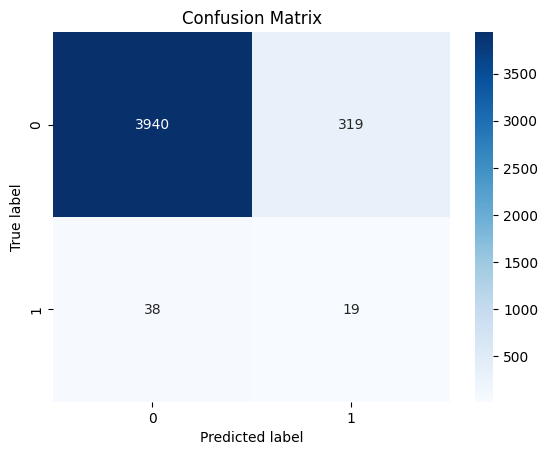

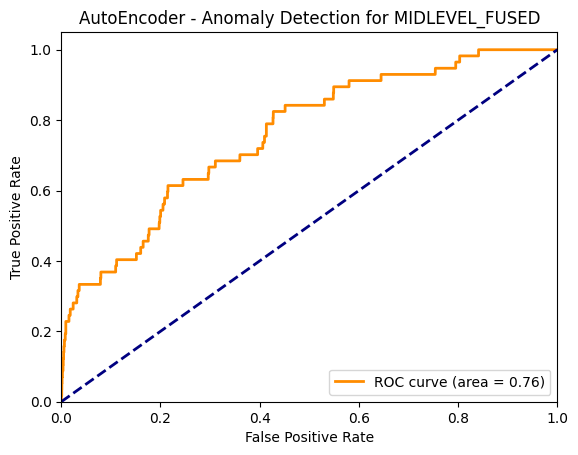

In [ ]:
def plot_roc_curve(y_true, scores, title):
    fpr, tpr, _ = roc_curve(y_true, scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

# Existing code for running the evaluation
for i, (model, (X, y), threshold) in enumerate(zip(models, data, thresholds)):
    print(f'#####################################')
    print(f'# {dataset_names[i].upper()} BEST MODEL')
    print(f'#####################################')
    print('Threshold: ', threshold)
    model.summary()

    # Compute reconstruction error and predict anomalies
    reconstruction_error = np.mean(np.power(X - model.predict(X), 2), axis=1)
    y_pred = [1 if e > threshold else 0 for e in reconstruction_error]
    conf_matrix = confusion_matrix(y, y_pred)

    # Print confusion matrix and classification report
    conf_matrix_and_classif_report(y, y_pred)

    # Plot ROC curve
    plot_roc_curve(y, reconstruction_error, f'AutoEncoder - Anomaly Detection for {dataset_names[i].upper()}')

##############################################################################
# Bayesian Decision Fusion with 2 models: Descriptors and Morgan Fingerprints
##############################################################################
135/135 [==============================] - 0s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.90      0.94      4259
           1       0.06      0.51      0.11        57

    accuracy                           0.89      4316
   macro avg       0.53      0.70      0.53      4316
weighted avg       0.98      0.89      0.93      4316

Confusion Matrix:


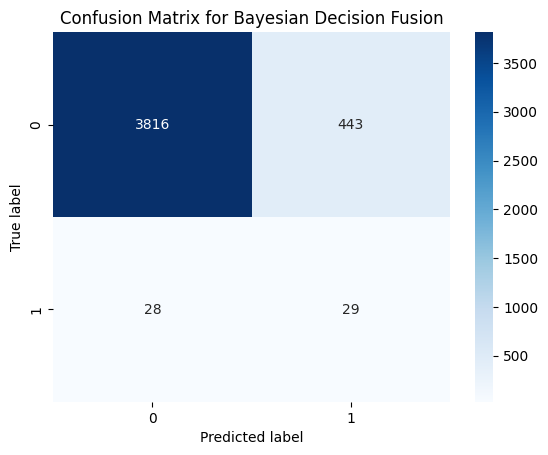

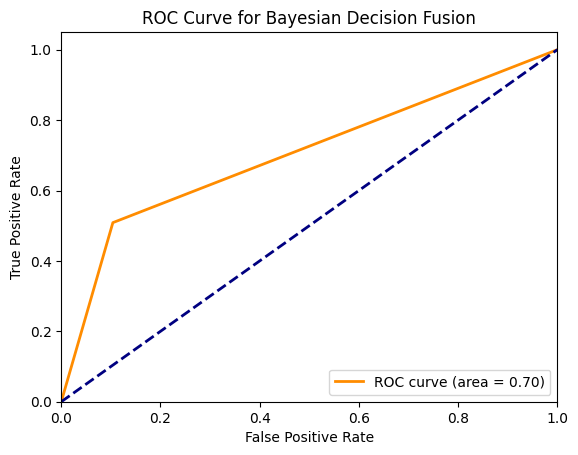

ROC AUC Score: 0.7024
##############################################################################
# Weighted Voting Fusion with 2 models: Descriptors and Morgan Fingerprints
##############################################################################
135/135 [==============================] - 0s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      4259
           1       0.12      0.21      0.15        57

    accuracy                           0.97      4316
   macro avg       0.55      0.59      0.57      4316
weighted avg       0.98      0.97      0.97      4316

Confusion Matrix:


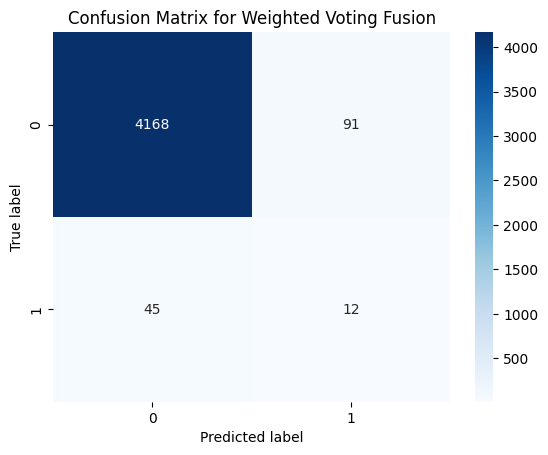

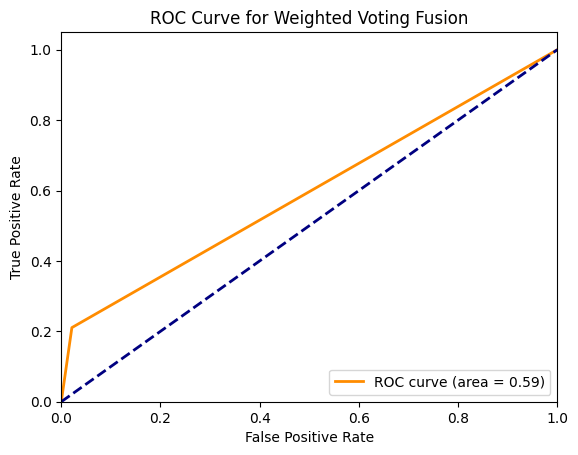

ROC AUC Score: 0.5946


In [ ]:
X_data = [X[0] for X in data[:2]]  # Extracting the X part from the data tuples
y_true = data[0][1]  # Assuming the true labels are the same for the first two models

def conf_matrix_aucroc_and_classif_report(true, pred, model_name):
    """
    Print the classification report, confusion matrix, plot ROC curve, and calculate ROC AUC score for the true labels and predictions.

    Parameters:
        true (array-like): The true labels.
        pred (array-like): The predicted labels.
        model_name (str): The name of the model or method being evaluated.

    Returns:
        None: The function prints the classification report, confusion matrix, plots the ROC curve, and ROC AUC score.
    """
    print('Classification Report:')
    print(classification_report(true, pred))

    print('Confusion Matrix:')
    conf_matrix = confusion_matrix(true, pred)
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

    # Calculate and plot ROC curve and AUC
    fpr, tpr, _ = roc_curve(true, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend(loc="lower right")
    plt.show()

    print(f'ROC AUC Score: {roc_auc:.4f}')

# Bayesian Decision Fusion with the first two models
print('##############################################################################')
print("# Bayesian Decision Fusion with 2 models: Descriptors and Morgan Fingerprints")
print('##############################################################################')
conf_matrices = confusion_matrices(models[:2], data[:2], thresholds[:2])
final_predictions_bayesian = bayesian_fusion_predict(models[:2], X_data, conf_matrices, thresholds[:2])
conf_matrix_aucroc_and_classif_report(y_true, final_predictions_bayesian, 'Bayesian Decision Fusion')

# Weighted Voting Fusion with the first two models
print('##############################################################################')
print("# Weighted Voting Fusion with 2 models: Descriptors and Morgan Fingerprints")
print('##############################################################################')
final_predictions_weighted = weighted_voting_fusion_autoencoder(models[:2], X_data, thresholds[:2])
conf_matrix_aucroc_and_classif_report(y_true, final_predictions_weighted, 'Weighted Voting Fusion')

## Find the best threshold:

#####################################
# DESCRIPTORS BEST MODEL
#####################################
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 189)]             0         
                                                                 
 dense (Dense)               (None, 48)                9120      
                                                                 
 dense_1 (Dense)             (None, 48)                2352      
                                                                 
 dense_2 (Dense)             (None, 189)               9261      
                                                                 
Total params: 20733 (80.99 KB)
Trainable params: 20733 (80.99 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
135/135 [==============================] - 0s 1ms/step
B

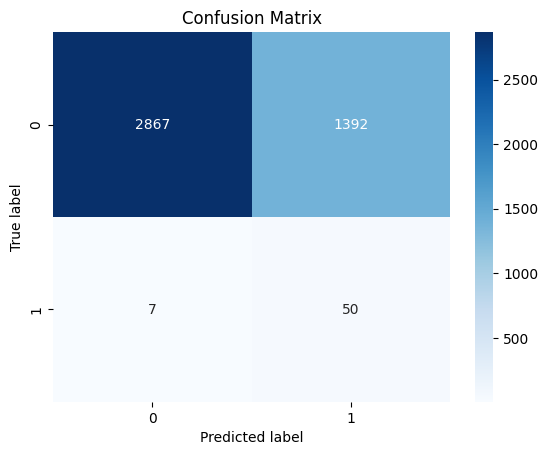

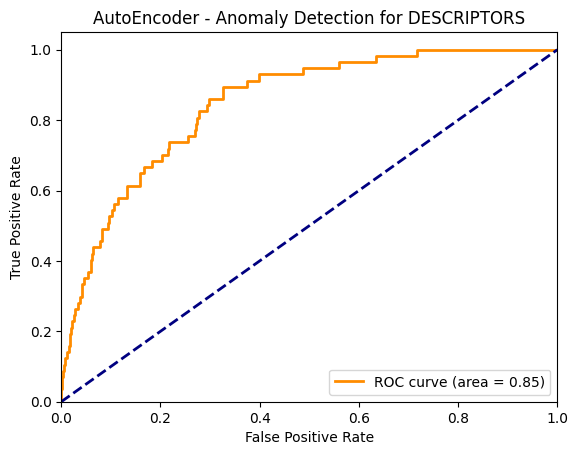

#####################################
# MORGAN_FP BEST MODEL
#####################################
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2048)]            0         
                                                                 
 dense (Dense)               (None, 752)               1540848   
                                                                 
 dense_1 (Dense)             (None, 752)               566256    
                                                                 
 dropout (Dropout)           (None, 752)               0         
                                                                 
 dense_2 (Dense)             (None, 2048)              1542144   
                                                                 
Total params: 3649248 (13.92 MB)
Trainable params: 3649248 (13.92 MB)
Non-trainable params: 0 

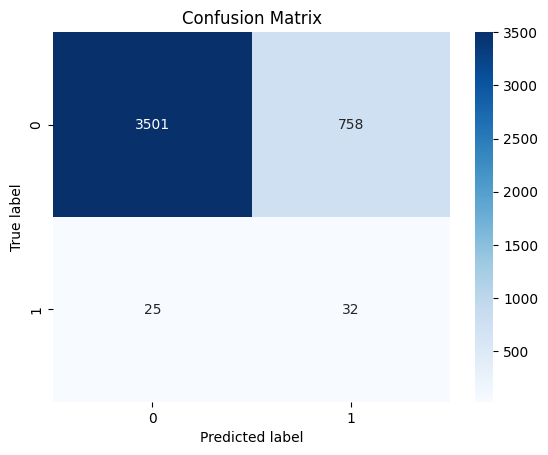

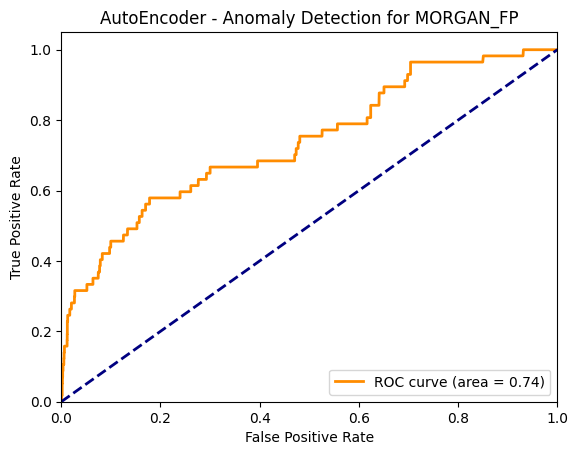

#####################################
# MIDLEVEL_FUSED BEST MODEL
#####################################
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2237)]            0         
                                                                 
 dense (Dense)               (None, 752)               1682976   
                                                                 
 dense_1 (Dense)             (None, 752)               566256    
                                                                 
 dropout (Dropout)           (None, 752)               0         
                                                                 
 dense_2 (Dense)             (None, 2237)              1684461   
                                                                 
Total params: 3933693 (15.01 MB)
Trainable params: 3933693 (15.01 MB)
Non-trainable param

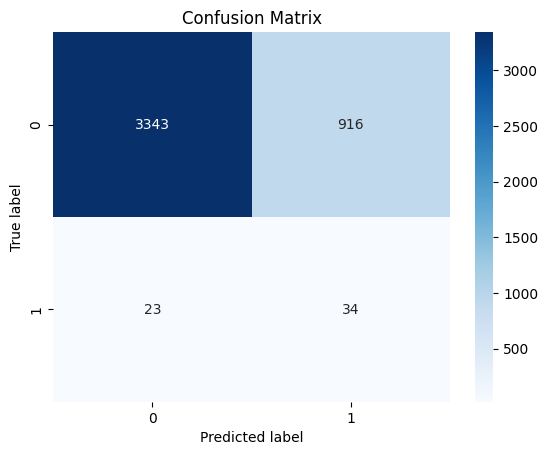

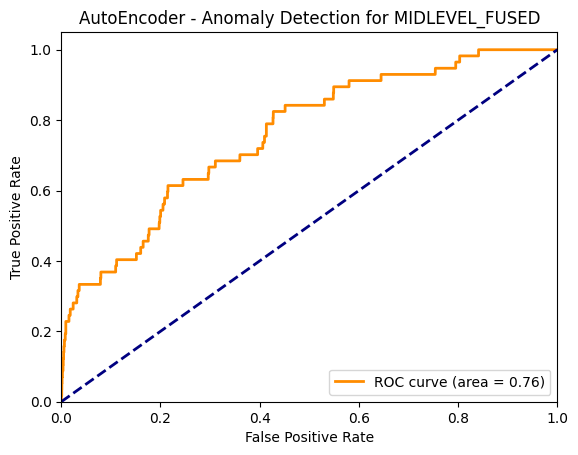

In [ ]:
def find_best_threshold(y_true, model_predictions):
    fpr, tpr, thresholds = roc_curve(y_true, model_predictions)
    roc_auc = auc(fpr, tpr)
    optimal_idx = np.argmax(tpr - fpr)
    best_threshold = thresholds[optimal_idx]
    return best_threshold, roc_auc


def plot_roc_curve(y_true, scores, title):
    fpr, tpr, _ = roc_curve(y_true, scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

best_thresholds=[]

# Existing code for running the evaluation
for i, (model, (X, y)) in enumerate(zip(models, data)):
    print(f'#####################################')
    print(f'# {dataset_names[i].upper()} BEST MODEL')
    print(f'#####################################')
    model.summary()

    # Compute reconstruction error
    reconstruction_error = np.mean(np.power(X - model.predict(X), 2), axis=1)

    # Find best threshold and corresponding AUC
    best_threshold, best_auc = find_best_threshold(y, reconstruction_error)
    print('Best Threshold: ', best_threshold)
    print('Best AUC: ', best_auc)

    best_thresholds.append(best_threshold)

    # Predict anomalies using the best threshold
    y_pred = [1 if e > best_threshold else 0 for e in reconstruction_error]
    conf_matrix = confusion_matrix(y, y_pred)

    # Print confusion matrix and classification report
    conf_matrix_and_classif_report(y, y_pred)

    # Plot ROC curve
    plot_roc_curve(y, reconstruction_error, f'AutoEncoder - Anomaly Detection for {dataset_names[i].upper()}')

##############################################################################
# Bayesian Decision Fusion with 2 models: Descriptors and Morgan Fingerprints
##############################################################################
135/135 [==============================] - 0s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.67      0.80      4259
           1       0.03      0.86      0.07        57

    accuracy                           0.68      4316
   macro avg       0.52      0.77      0.43      4316
weighted avg       0.98      0.68      0.79      4316

Confusion Matrix:


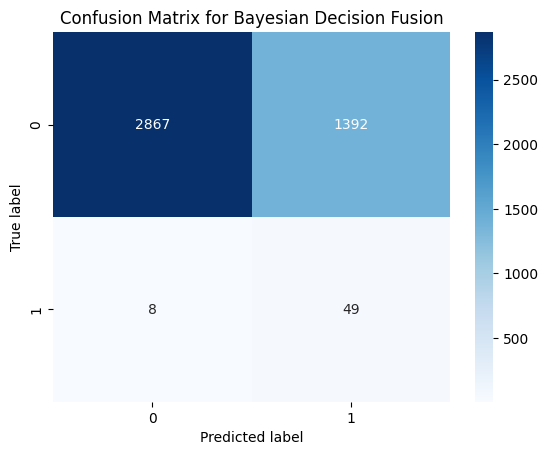

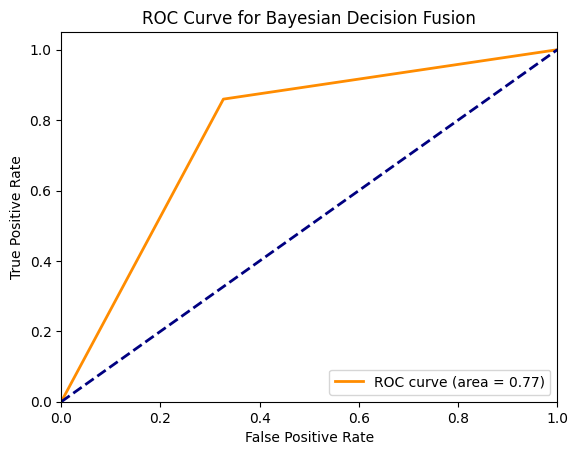

ROC AUC Score: 0.7664
##############################################################################
# Weighted Voting Fusion with 2 models: Descriptors and Morgan Fingerprints
##############################################################################
135/135 [==============================] - 0s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.90      0.94      4259
           1       0.07      0.54      0.12        57

    accuracy                           0.89      4316
   macro avg       0.53      0.72      0.53      4316
weighted avg       0.98      0.89      0.93      4316

Confusion Matrix:


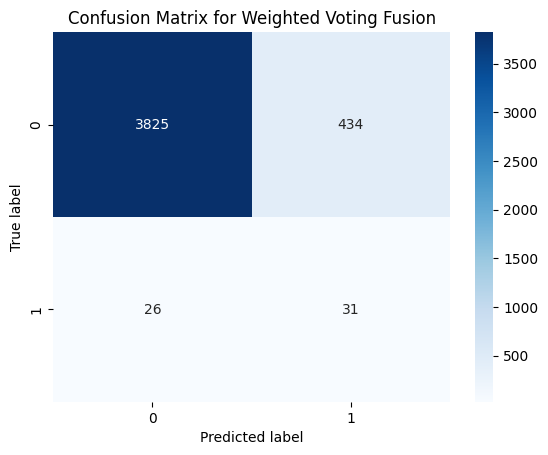

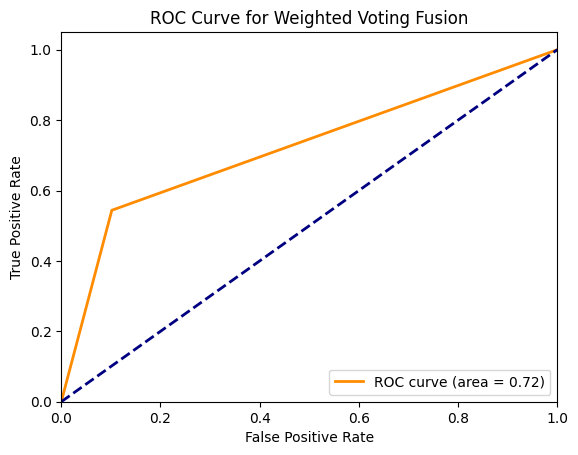

ROC AUC Score: 0.7210


In [ ]:
thresholds = best_thresholds
X_data = [X[0] for X in data[:2]]  # Extracting the X part from the data tuples
y_true = data[0][1]  # Assuming the true labels are the same for the first two models

def conf_matrix_aucroc_and_classif_report(true, pred, model_name):
    """
    Print the classification report, confusion matrix, plot ROC curve, and calculate ROC AUC score for the true labels and predictions.

    Parameters:
        true (array-like): The true labels.
        pred (array-like): The predicted labels.
        model_name (str): The name of the model or method being evaluated.

    Returns:
        None: The function prints the classification report, confusion matrix, plots the ROC curve, and ROC AUC score.
    """
    print('Classification Report:')
    print(classification_report(true, pred))

    print('Confusion Matrix:')
    conf_matrix = confusion_matrix(true, pred)
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

    # Calculate and plot ROC curve and AUC
    fpr, tpr, _ = roc_curve(true, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend(loc="lower right")
    plt.show()

    print(f'ROC AUC Score: {roc_auc:.4f}')

# Bayesian Decision Fusion with the first two models
print('##############################################################################')
print("# Bayesian Decision Fusion with 2 models: Descriptors and Morgan Fingerprints")
print('##############################################################################')
conf_matrices = confusion_matrices(models[:2], data[:2], thresholds[:2])
final_predictions_bayesian = bayesian_fusion_predict(models[:2], X_data, conf_matrices, thresholds[:2])
conf_matrix_aucroc_and_classif_report(y_true, final_predictions_bayesian, 'Bayesian Decision Fusion')

# Weighted Voting Fusion with the first two models
print('##############################################################################')
print("# Weighted Voting Fusion with 2 models: Descriptors and Morgan Fingerprints")
print('##############################################################################')
final_predictions_weighted = weighted_voting_fusion_autoencoder(models[:2], X_data, thresholds[:2])
conf_matrix_aucroc_and_classif_report(y_true, final_predictions_weighted, 'Weighted Voting Fusion')